In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

import plotly.express as px

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

You can check a burst's GBM detectors by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

--- 

- FullCatalog.fits holds ALL GRB sources contained in the 2nd Fermi-LAT GRB Catalog
- RS=null.fits holds GRBs which have a null in the redshift parameter
---

In order to find T90/T50 for sources in the GBM catalog, we need to import the GBM catalog and join on the GRB names in the LAT catalog.

` pd.join( on='left') `

calc and propagate the ratio

turns out LAT actually calculates the index under late_index and late_index_error

In [196]:
### Helper functions -- always run this cell

def clean_data(targets):
    # Cleans columns & GRB names
    
    # Remove trailing whitespace
    targets = targets.rename(columns=lambda x: x.strip().lower())
    # Cleans GRB names
    targets['name'] = targets['name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)#[1:]
    #targets['gcn_name'] = targets['gcn_name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)[1:]

    return targets

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

def calculate_hardness(targets):
    # Calculates flux, flux_ene & fluence ratios with corresponding error
    targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
    targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
    targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']
    targets['hardness'] = targets['like_lat_fluence']/targets['like_gbm_fluence']



    targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                                  targets['like_lat_flux'],
                                                  targets['like_gbm_flux_error'],
                                                  targets['like_lat_flux_error'])

    targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                      targets['like_lat_flux_ene'],
                                                      targets['like_gbm_flux_ene_error'],
                                                      targets['like_lat_flux_ene_error'])

    targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                      targets['like_lat_fluence'],
                                                      targets['like_gbm_fluence_error'],
                                                      targets['like_lat_fluence_error'])
    
    targets['hardness_error'] = propagate_error(targets['like_lat_fluence'],
                                                targets['like_gbm_fluence'],
                                                targets['like_lat_fluence_error'],
                                                targets['like_gbm_fluence_error'])
    return targets

def calculate_time_difference(targets):
    # Calculate like & gbm-lle time differences
    targets['like_gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']
    targets['gbm-lle_t90_difference'] = targets['gbm_cat_t90'] - targets['lle_t90']
    return targets

def calculate_ratio(targets):
    # T90/T50 ratio + propagated error
    # Only have T90/T50 for GBM which is fine, cause apparently LAT has lc index anyway
    targets['gbm_t9050'] = targets['t90']/targets['t50']
    targets['gbm_t9050_error'] = propagate_error(targets['t90'], targets['t50'], targets['t90_error'], targets['t50_error'])
    return targets

In [197]:
# Load the datasets
LAT = Table.read('./LATCatalog.fits').to_pandas()
GBM = Table.read('./GBMCatalog.fits').to_pandas()

LAT = clean_data(LAT)
GBM = clean_data(GBM)

# Calculate ratio for GBM
GBM = calculate_ratio(GBM)

# Merge datasets
all_candidates = pd.merge(left = LAT, right = GBM, on = 'name', how = 'left')

# Calculate merge ratios
all_candidates = calculate_hardness(all_candidates)
all_candidates = calculate_time_difference(all_candidates)

all_candidates.T.tail(12).T.describe()

,gbm_t9050,gbm_t9050_error,flux_ratio,flux_ene_ratio,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
count,220.0,220.000000,223.0,223.0,223.0,223.0,157.0,157.0,157.0,157.0,231.0,231.0
unique,213.0,220.000000,159.0,159.0,159.0,159.0,143.0,143.0,143.0,143.0,222.0,226.0
top,2.0,0.198272,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,60.0
freq,6.0,1.000000,58.0,58.0,58.0,58.0,15.0,15.0,15.0,15.0,8.0,3.0


In [256]:
cols = ['name', 'gbm_t9050', 'gbm_t9050_error', 'lat_spl_index1', 'lat_spl_index1_error']
all_candidates[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 0 to 230
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  231 non-null    object 
 1   gbm_t9050             220 non-null    float64
 2   gbm_t9050_error       220 non-null    float64
 3   lat_spl_index1        231 non-null    float64
 4   lat_spl_index1_error  231 non-null    float64
dtypes: float64(4), object(1)
memory usage: 10.8+ KB


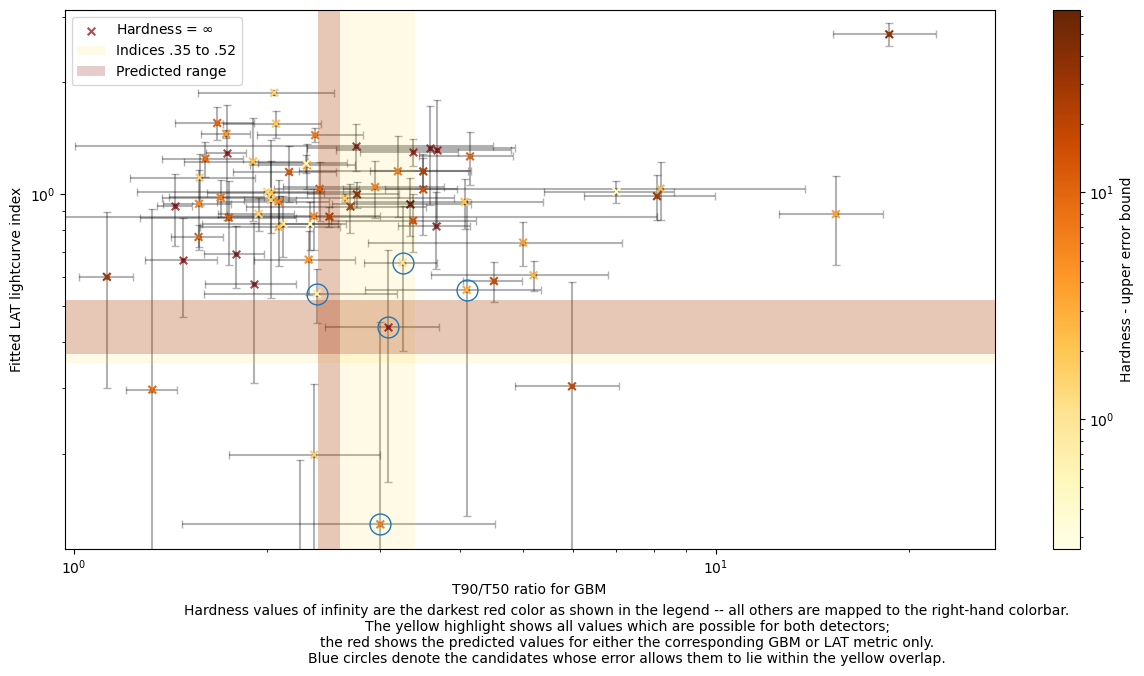

In [247]:
# Only unassociated candidates
candidates = all_candidates.query('redshift == 0')

fig, ax = plt.subplots()

# Plot the candidates with color by hardness
sx = ax.scatter(candidates['gbm_t9050'], candidates['lat_spl_index1'], marker = 'x', \
    c=(candidates['hardness'] + candidates['hardness_error']), \
    s=30, cmap='YlOrBr', norm=matplotlib.colors.LogNorm(), zorder = 3)
fig.colorbar(sx, ax=ax, label = 'Hardness - upper error bound', orientation = 'vertical')

# Re-plot the candidates with 'infinite' hardness i.e. invisible to GBM
# We skip the candidates with 0 hardness because our models show that a source MUST have LAT appear BEFORE GBM
inf = np.infty
_ = candidates.query('hardness == @inf')
ax.scatter(_['gbm_t9050'], _['lat_spl_index1'], color='darkred', marker='x', s=30, \
    label = f'Hardness = $\infty$', alpha=.7, zorder = 4)


ax.set_yscale('log')
ax.set_xscale('log')
# Save the lims before we apply the errorbar (since the errorbars stretch the lims a ton)
xl = fig.gca().get_xlim()
yl = fig.gca().get_ylim()

# Apply errorbars
ax.errorbar(candidates['gbm_t9050'], candidates['lat_spl_index1'], \
    xerr = candidates['gbm_t9050_error'], yerr = candidates['lat_spl_index1_error'], \
    fmt='o', linewidth=1.5, capsize=3, \
    color='black', markersize=3, alpha=.3, zorder = 1)


# Show expected limits for each of the variables
ax.axhspan(.35, .52, facecolor='gold', alpha=.1, label = 'Indices .35 to .52', zorder = 2)
ax.axvspan(2.4, 3.4, facecolor='gold', alpha=.1, zorder = 2)
ax.axhspan(.37, .52, facecolor='darkred', alpha=.2, label = 'Predicted range', zorder = 2)
ax.axvspan(2.4, 2.6, facecolor='darkred', alpha=.2, zorder = 2)


# Reset plot limits
ax.set_xlim(xl)
ax.set_ylim(yl)
ax.set_xlabel('T90/T50 ratio for GBM')
ax.set_ylabel('Fitted LAT lightcurve index')
ax.legend()

names = ['GRB150702998', 'GRB091120191', 'GRB171210493', 'GRB110120666', 'GRB130325203']
for name in names:
    it = all_candidates.loc[ all_candidates['name'] == name].iloc[0]
    ax.plot(it['gbm_t9050'], it['lat_spl_index1'], color = 'C0', \
        marker = '.', markerfacecolor = 'none', markersize = 30, zorder = 5)

# top_3 = candidates.query('hardness_upper > 14.6 & hardness < 40.3').query('gbm_cat_t90 > 50')
# ax.errorbar(top_3['gbm_cat_t90'], top_3['hardness'], 
# yerr = top_3['hardness_error'], 
# fmt='o', linewidth=1.5, capsize=3,
# color='darkred', markersize=3, label = 'Preliminary top 3')



# # Estimated hardness
# """
# NaI
# lower=14.6
# higher=40.3
# BGO
# lower=1.2
# higher=3.36
# """
# ax.axhline(40.3, linestyle='-', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, upper')
# ax.axhline(14.6, linestyle='-.', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, lower')
# ax.axhspan(14.6, 40.3, facecolor='darkred', alpha=.1, label ='Expected LAT/NaI hardness')

# ax.axhline(3.36, linestyle='-', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, upper')
# ax.axhline(1.2, linestyle='-.', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, lower')
# ax.axhspan(1.2, 3.36, facecolor='blue', alpha=.1, label = 'Expected LAT/BGO hardness')


# # Previous estimation
# ax.axvline(0.1, linestyle='--',  label = r'Previous search: $\tau$ = 0.1s', color='black', alpha=.4)

# # GBM energies
# ax.axvline(252, linestyle='--',  label = r'GBM BGO 1MeV', color='orange', alpha=.4)
# ax.axvline(267, linestyle='-.',  label = r'GBM BGO 8keV', color='orange', alpha=.4)
# ax.axvline(284, linestyle='-',  label = r'GBM NaI 200keV', color='orange', alpha=.4)
# ax.axvline(183, linestyle='-',  label = r'LAT 20MeV', color='green', alpha=.4)

# ax.axvspan(252, 284, color='orange', alpha=.1)

# ax.legend()

plt.figtext(0.5, -0.05, 'Hardness values of infinity are the darkest red color as shown in the legend -- all others are mapped to the right-hand colorbar.\n' + \
    'The yellow highlight shows all values which are possible for both detectors;\n' + \
    'the red shows the predicted values for either the corresponding GBM or LAT metric only.\n' + \
    'Blue circles denote the candidates whose error allows them to lie within the yellow overlap.', \
    wrap=True, horizontalalignment='center', fontsize=10)

#ax.set_title('GBM T90 vs. Hardness upper-bound')

fig.set_figwidth(15)
fig.set_figheight(7)
fig.savefig('Ratio+Index+Hardness.png', dpi=500)
fig.show()

In [236]:
all_candidates.query('gbm_t9050 < 5 & gbm_t9050 > 2.5 & lat_spl_index1 < .3 & lat_spl_index1 > 0')

,name,gcn_name,time,trigger_met,ra_x,dec_x,lii_x,bii_x,error_radius_x,redshift,...,flux_ratio,flux_ene_ratio,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
87,GRB130325203,b'GRB130325A ',56376.202708,385879917.3,122.97,-19.15,239.3172,8.0184,0.18,0.0,...,141.442607,32.191549,0.315318,3.171399,103.294584,31.402428,0.307589,3.017822,-323.31199,6.912


------

Hardness > 1
GBM T90 in []

In [187]:
selected_candidates = all_candidates.query('redshift == 0 & hardness > 1').query(
     '(gbm_cat_t90 > 200 & gbm_cat_t90 < 350) | (lle_t90 < 200 & lle_t90 > 30)'
)

unassoc_hard_candidates = all_candidates.query('redshift == 0 & hardness > 1')
unassoc_hard_candidates['hardness_upper'] = unassoc_hard_candidates['hardness'] + unassoc_hard_candidates['hardness_error']

There are a bunch of quirks in this dataset:
- There are 'infinite' hardnesses. This is because the GBM fluence was registered as 0.
- A bunch of the sources are lle_t90 = 0. This accounts for 

In [188]:

print('Total unassociated sources: %s'%unassoc_hard_candidates.shape[0])

print( 'N. sources with lle_t90 = 0.: %s'%unassoc_hard_candidates.query('lle_t90==0').shape[0])

inf = np.infty
print( 'N. sources with infinite hardness: %s'% unassoc_hard_candidates.query('hardness == @inf').shape[0])
print( 'N. sources that are lle_t90 = 0. AND have infinite hardness: %s'%unassoc_hard_candidates.query('lle_t90==0 & hardness==@inf').shape[0])


print('N. sources with GBM t90=0.: %s'%unassoc_hard_candidates.query('gbm_cat_t90 == 0').shape[0])

Total unassociated sources: 138
N. sources with lle_t90 = 0.: 77
N. sources with infinite hardness: 43
N. sources that are lle_t90 = 0. AND have infinite hardness: 37
N. sources with GBM t90=0.: 0


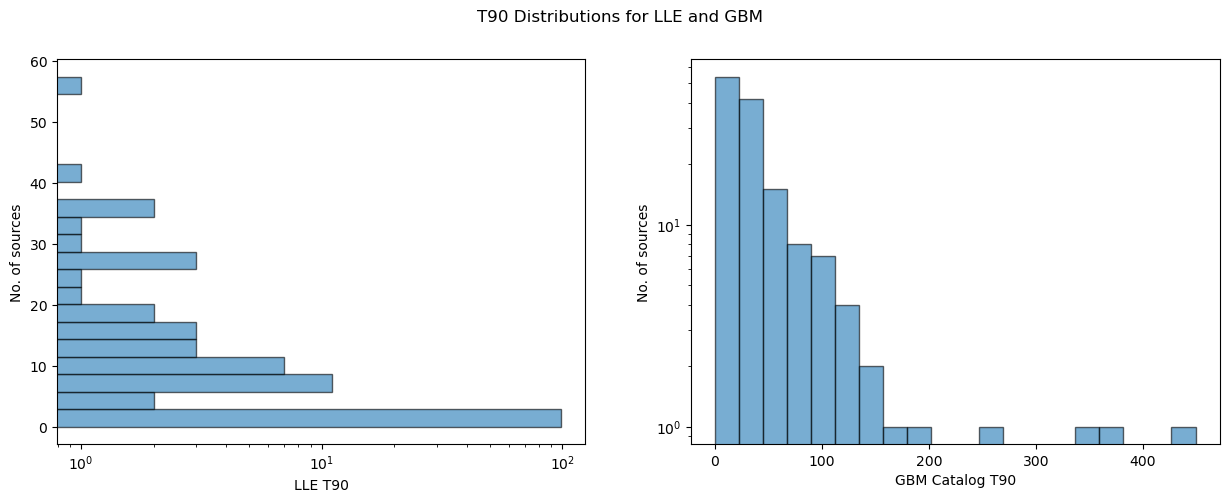

In [189]:
fig, ax = plt.subplots(1,2)
ax[0].hist(unassoc_hard_candidates['lle_t90'], alpha = 0.6, edgecolor='black', bins=20, orientation='horizontal')
ax[0].set_xscale('log')
ax[0].set_xlabel('LLE T90')
ax[0].set_ylabel('No. of sources')

ax[1].hist(unassoc_hard_candidates['gbm_cat_t90'], alpha = 0.6, edgecolor='black', bins=20)
ax[1].set_yscale('log')
ax[1].set_xlabel('GBM Catalog T90')
ax[1].set_ylabel('No. of sources')

fig.suptitle('T90 Distributions for LLE and GBM')

fig.set_figwidth(15)
fig.set_figheight(5)
fig.show()

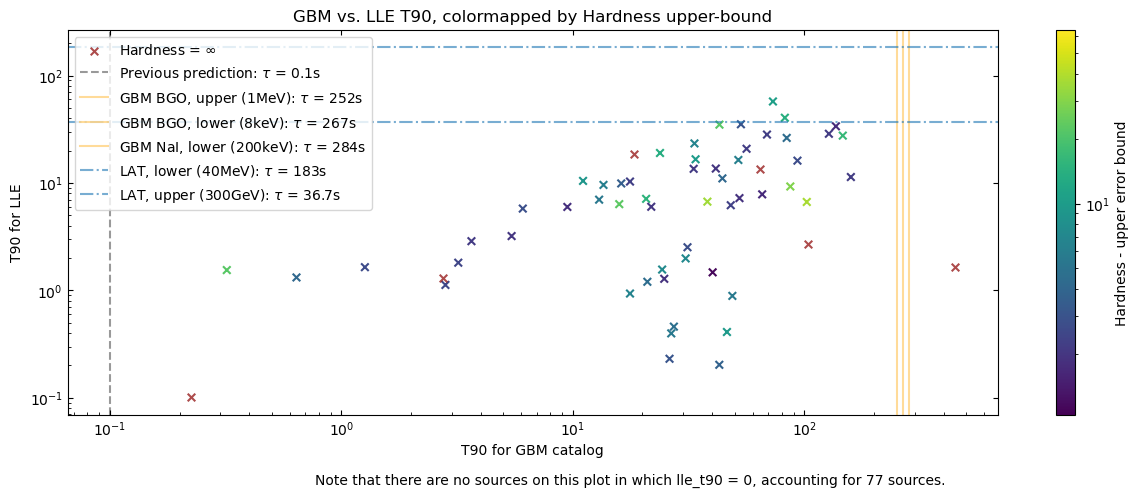

In [190]:
fig, ax = plt.subplots()

# Scatter plot all objects.
sx = ax.scatter(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['lle_t90'], marker = 'x', c=(unassoc_hard_candidates['hardness_upper']),
 s=30, cmap='viridis', norm=matplotlib.colors.LogNorm())
fig.colorbar(sx, ax=ax, label = 'Hardness - upper error bound', orientation = 'vertical')

# Include the objects with 'infinite' hardness.
inf = np.infty
_ = unassoc_hard_candidates.query('hardness == @inf')
ax.scatter(_['gbm_cat_t90'], _['lle_t90'], color='darkred', marker='x', s=30, label = f'Hardness = $\infty$', alpha=.7)

# Previous estimation
ax.axvline(0.1, linestyle='--',  label = r'Previous prediction: $\tau$ = 0.1s', color='black', alpha=.4)

# GBM energies
ax.axvline(252, linestyle='-',  label = r'GBM BGO, upper (1MeV): $\tau$ = 252s', color='orange', alpha=.4)
ax.axvline(267, linestyle='-',  label = r'GBM BGO, lower (8keV): $\tau$ = 267s', color='orange', alpha=.4)
ax.axvline(284, linestyle='-',  label = r'GBM NaI, lower (200keV): $\tau$ = 284s', color='orange', alpha=.4)

# LAT energies
ax.axhline(183, linestyle='-.',  label = r'LAT, lower (40MeV): $\tau$ = 183s', alpha=.6)
ax.axhline(36.7, linestyle='-.',  label = r'LAT, upper (300GeV): $\tau$ = 36.7s', alpha=.6)

# Labels
ax.set_ylabel('T90 for LLE')
ax.set_xlabel('T90 for GBM catalog')

# Log scale
ax.set_xscale('log')
ax.set_yscale('log')

# x, yticks on inside & on top/right
ax.tick_params(axis="x", bottom=True, top=True)
ax.tick_params(axis="y", left=True, right=True)
ax.tick_params(axis="both", which="both", direction="in")

plt.figtext(0.5, -0.03, 'Note that there are no sources on this plot in which lle_t90 = 0, accounting for 77 sources.', wrap=True, horizontalalignment='center', fontsize=10)

fig.set_figwidth(15)
fig.set_figheight(5)
ax.legend()

ax.set_title('GBM vs. LLE T90, colormapped by Hardness upper-bound')

fig.show()

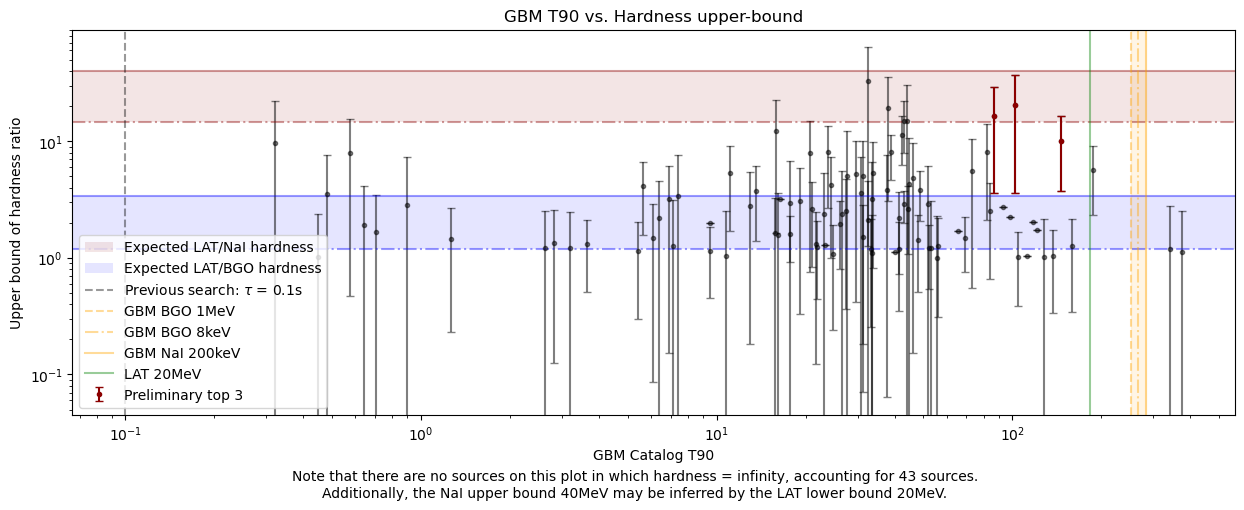

In [203]:
# In that spirit, let's focus mainly on the GBM T90.

fig, ax = plt.subplots()

#ax.scatter(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['hardness_upper'], marker='x', color='black', s=20)
ax.errorbar(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['hardness'], 
yerr = unassoc_hard_candidates['hardness_error'], 
fmt='o', linewidth=1.5, capsize=3,
color='black', markersize=3, alpha=.5)

top_3 = unassoc_hard_candidates.query('hardness_upper > 14.6 & hardness < 40.3').query('gbm_cat_t90 > 50')
ax.errorbar(top_3['gbm_cat_t90'], top_3['hardness'], 
yerr = top_3['hardness_error'], 
fmt='o', linewidth=1.5, capsize=3,
color='darkred', markersize=3, label = 'Preliminary top 3')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('GBM Catalog T90')
ax.set_ylabel('Upper bound of hardness ratio')

# Estimated hardness
"""
NaI
lower=14.6
higher=40.3
BGO
lower=1.2
higher=3.36
"""
ax.axhline(40.3, linestyle='-', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, upper')
ax.axhline(14.6, linestyle='-.', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, lower')
ax.axhspan(14.6, 40.3, facecolor='darkred', alpha=.1, label ='Expected LAT/NaI hardness')

ax.axhline(3.36, linestyle='-', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, upper')
ax.axhline(1.2, linestyle='-.', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, lower')
ax.axhspan(1.2, 3.36, facecolor='blue', alpha=.1, label = 'Expected LAT/BGO hardness')


# Previous estimation
ax.axvline(0.1, linestyle='--',  label = r'Previous search: $\tau$ = 0.1s', color='black', alpha=.4)

# GBM energies
ax.axvline(252, linestyle='--',  label = r'GBM BGO 1MeV', color='orange', alpha=.4)
ax.axvline(267, linestyle='-.',  label = r'GBM BGO 8keV', color='orange', alpha=.4)
ax.axvline(284, linestyle='-',  label = r'GBM NaI 200keV', color='orange', alpha=.4)
ax.axvline(183, linestyle='-',  label = r'LAT 20MeV', color='green', alpha=.4)

ax.axvspan(252, 284, color='orange', alpha=.1)

ax.legend()

plt.figtext(0.5, -0.05, 'Note that there are no sources on this plot in which hardness = infinity, accounting for 43 sources.\n'+\
'Additionally, the NaI upper bound 40MeV may be inferred by the LAT lower bound 20MeV.',
 wrap=True, horizontalalignment='center', fontsize=10)

ax.set_title('GBM T90 vs. Hardness upper-bound')

fig.set_figwidth(15)
fig.set_figheight(5)
fig.savefig('GBM_vs_Hardness.png')
fig.show()

In [202]:
str = '['
for name in top_3.name:
    str += '"%s", '%name
str[:-2] + ']'

'["GRB130821674", "GRB140206275", "GRB100116897"]'

--------

In [4]:
selected_candidates = all_candidates.query('redshift == 0 & hardness > 1').query(
     '(gbm_cat_t90 > 200 & gbm_cat_t90 < 350) | (lle_t90 < 200 & lle_t90 > 30)'
)

px.scatter(selected_candidates, x='gbm_cat_t90', y='lle_t90', color='hardness')

In [7]:
all_candidates['log_hardness'] = np.log(all_candidates['hardness'])
fig = px.scatter(all_candidates.query('redshift == 0 & hardness > 1'), x='gbm_cat_t90', y='lle_t90', color='log_hardness', log_y=True, log_x=True)
fig